In [3]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/DataFusionContest/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import io
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import pickle

In [5]:
df = pd.read_csv('clean.csv')

In [6]:
# Получение списка уникальных значений категорий товара для кодирования методом
# One Hot Encoding
cols = list(df['category_id'].unique())
cols.sort()
print(cols)
dummiesColumnsName = []
for i in range(len(cols)):
    dummiesColumnsName.append(str(cols[i]))
print(dummiesColumnsName)

[0, 1, 2, 3, 4, 6, 7, 9, 11, 12, 13, 19, 20, 24, 26, 27, 29, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 90, 92, 96, 97, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 114, 115, 117, 118, 120, 121, 128, 130, 133, 138, 139, 140, 143, 145, 150, 163, 164, 167, 177, 203, 204]
['0', '1', '2', '3', '4', '6', '7', '9', '11', '12', '13', '19', '20', '24', '26', '27', '29', '30', '31', '35', '36', '37', '38', '39', '40', '41', '42', '43', '45', '46', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '60', '61', '62', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '90', '92', '96', '97', '100', '101', '102', '103', '105', '106', '107', '108', '109', '111', '114', '115', '117', '118', '120', '121', '128', '130', '133', '138', '139', '140', '143', '145', '150', '163', '164', 

In [7]:
# Обработка тренировочного датасета
df['item_name'] = df['item_name'].str.lower()
df = df.sample(frac=1).reset_index(drop=True)
print(df.head())

                                item_name  category_id
0                 домофон (входная дверь)          106
1                                  пробка          111
2  омыватель стекла летний hubba bubba 5л           12
3                 кофе латтемакиато 200мл           70
4                             инта вир 8г          140


In [8]:
# Использование токенайзера для преобразования названия товара (item_name)
# Фильтры:
to_exclude = '".,:!?#$%&()*+-/<=>@[\\]^_`{|}~\t\n' # Исключаемые символы
to_tokenize = '.,:!?"' # Обрабатываемые символы

# Обучение токенайзера
num_words = 20000 # Максимальное количество слов в словаре
max_review_len = 100 # Максимальное количество слов в названии товара
tokenizer_goods = Tokenizer(num_words=num_words, filters=to_exclude, oov_token=1)
tokenizer_goods.fit_on_texts(df['item_name'])

print('Обучение завершено')

# Сохранение полученного словаря
tokenizer_json = tokenizer_goods.to_json()
with io.open('tokenizer_item_name.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

print('Результат успешно сохранен')

# Загрузка словаря токенайзера
with open('tokenizer_item_name.json') as f:
    data = json.load(f)
    tokenizer_goods = tokenizer_from_json(data)

print('Словарь токенайзер загружен')

# Обработка по полученному словарю
sequences_goods = tokenizer_goods.texts_to_sequences(df['item_name'])
max_position_len=10
xTrain = pad_sequences(sequences_goods, maxlen=max_position_len)
print(xTrain[0])

Обучение завершено
Результат успешно сохранен
Словарь токенайзер загружен
[   0    0    0    0    0    0    0  969 1121 1013]


In [9]:
yTrain = pd.DataFrame(np.zeros((len(df), len(cols)), dtype=np.uint8), columns=dummiesColumnsName)
for i in range(len(df)):
    j = df.loc[i, 'category_id']
    yTrain.loc[i, str(j)] = 1
print(df.loc[0, 'category_id'])
print(yTrain.loc[0, '70'])

106
0


In [10]:
print(xTrain.shape[1])

10


In [11]:
print(yTrain.loc[0, '106'])

1


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 64)            1280000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 98)                1264

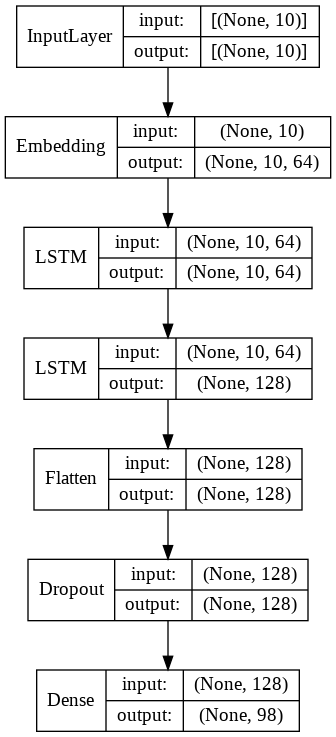

In [16]:
from tensorflow.keras import Input, Model, models, optimizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, concatenate, Flatten, Embedding
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

lstm_drop = 0.1
inputShape = (xTrain.shape[1])
modelIn = Input(shape=inputShape)
embeddingLayer = Embedding(num_words, 64) (modelIn)
lstmLayer1 = LSTM(64, dropout = lstm_drop, return_sequences=True)(embeddingLayer)
lstmLayer2 = LSTM(128, dropout = lstm_drop)(lstmLayer1)
flattenLayer = Flatten()(lstmLayer2)
dropoutLayer = Dropout(0.1)(flattenLayer)
modelOut = Dense(98,activation="softmax")(dropoutLayer)#tanh sigmoid softmax activation="sigmoid"
model=Model([modelIn], [modelOut])

loss='categorical_crossentropy' #binary_crossentropy categorical_crossentropy mae
optimiser=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
metrics1='accuracy'# mae accuracy
model.compile(optimizer=optimiser, 
              loss=loss, 
              metrics=[metrics1])
model.summary()
plot_model(model, to_file='model_plot.png', expand_nested=True, show_shapes=True, show_layer_names=False)

In [13]:
k = len(xTrain)
x_train = xTrain[:int(0.9 * k)]
y_train = yTrain[:int(0.9 * k)]
x_test = xTrain[int(0.9 * k):]
y_test = yTrain[int(0.9 * k):]

In [15]:
print(y_train.shape)

(491803, 98)


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint #, EarlyStopping,Callback
#training model
callbacks = [
    ModelCheckpoint('best_result_checkpoint', monitor='val_loss', save_best_only=True, verbose=0)
]

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=20,
                    batch_size=16,
                    callbacks=callbacks #,
                    #shuffle=True
                    )

Epoch 1/20
30738/30738 [==============================] - 455s 15ms/step - loss: 2.1441 - accuracy: 0.5329 - val_loss: 0.2272 - val_accuracy: 0.9431


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 2/20
30738/30738 [==============================] - 430s 14ms/step - loss: 0.1944 - accuracy: 0.9478 - val_loss: 0.1423 - val_accuracy: 0.9571


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 3/20
30738/30738 [==============================] - 427s 14ms/step - loss: 0.1236 - accuracy: 0.9604 - val_loss: 0.1227 - val_accuracy: 0.9602


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 4/20
30738/30738 [==============================] - 432s 14ms/step - loss: 0.1025 - accuracy: 0.9642 - val_loss: 0.1099 - val_accuracy: 0.9628


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 5/20
30738/30738 [==============================] - 429s 14ms/step - loss: 0.0919 - accuracy: 0.9665 - val_loss: 0.1048 - val_accuracy: 0.9640


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 6/20
30738/30738 [==============================] - 441s 14ms/step - loss: 0.0876 - accuracy: 0.9666 - val_loss: 0.1013 - val_accuracy: 0.9652


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 7/20
30738/30738 [==============================] - 437s 14ms/step - loss: 0.0831 - accuracy: 0.9680 - val_loss: 0.0980 - val_accuracy: 0.9659


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 8/20
30738/30738 [==============================] - 438s 14ms/step - loss: 0.0801 - accuracy: 0.9686 - val_loss: 0.0965 - val_accuracy: 0.9661


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 9/20
30738/30738 [==============================] - 438s 14ms/step - loss: 0.0769 - accuracy: 0.9696 - val_loss: 0.0954 - val_accuracy: 0.9663


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 10/20
30738/30738 [==============================] - 451s 15ms/step - loss: 0.0765 - accuracy: 0.9692 - val_loss: 0.0931 - val_accuracy: 0.9669


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 11/20
30738/30738 [==============================] - 445s 14ms/step - loss: 0.0743 - accuracy: 0.9698 - val_loss: 0.0917 - val_accuracy: 0.9673


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 12/20
30738/30738 [==============================] - 437s 14ms/step - loss: 0.0729 - accuracy: 0.9701 - val_loss: 0.0905 - val_accuracy: 0.9670


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 13/20
30738/30738 [==============================] - 445s 14ms/step - loss: 0.0725 - accuracy: 0.9699 - val_loss: 0.0911 - val_accuracy: 0.9676
Epoch 14/20
30738/30738 [==============================] - 462s 15ms/step - loss: 0.0707 - accuracy: 0.9702 - val_loss: 0.0894 - val_accuracy: 0.9676


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 15/20
30738/30738 [==============================] - 451s 15ms/step - loss: 0.0690 - accuracy: 0.9710 - val_loss: 0.0887 - val_accuracy: 0.9679


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 16/20
30738/30738 [==============================] - 456s 15ms/step - loss: 0.0689 - accuracy: 0.9711 - val_loss: 0.0890 - val_accuracy: 0.9677
Epoch 17/20
30738/30738 [==============================] - 471s 15ms/step - loss: 0.0689 - accuracy: 0.9708 - val_loss: 0.0886 - val_accuracy: 0.9679


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 18/20
30738/30738 [==============================] - 455s 15ms/step - loss: 0.0678 - accuracy: 0.9712 - val_loss: 0.0881 - val_accuracy: 0.9677


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


Epoch 19/20
30738/30738 [==============================] - 454s 15ms/step - loss: 0.0673 - accuracy: 0.9713 - val_loss: 0.0885 - val_accuracy: 0.9681
Epoch 20/20
30738/30738 [==============================] - 472s 15ms/step - loss: 0.0659 - accuracy: 0.9717 - val_loss: 0.0869 - val_accuracy: 0.9684


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


INFO:tensorflow:Assets written to: best_result_checkpoint/assets


In [18]:
model=models.load_model('best_result_checkpoint')
#save model
model_json = model.to_json()
json_file = open('model_v3.json', 'w')
#write structure
json_file.write(model_json)
json_file.close()
# write wtights
model.save_weights('model_v3.h5')
print('Saving done')

Saving done


In [ ]:
z_real['category_id'] = z_real['category_id'].astype('uint8')
print(accuracy_score(z_pred, z_real))

0.99394


При 100 деревьях было 0.99492